## Welcome
This is the notebook from **Zihao Zhou** for Battery.DEV 2022 Challenge II - **BBOX Field Data**  
Our team includes Yannick Kuhn, Srinath Kannou, Nishank Navelkar and Zihao Zhou  



In [3]:
import numpy as np
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

## Data Observation

In [4]:
# Load all the .csv files in the data folder (may takes 2-3 minutes)
all_df = pd.read_csv('data/devices1.csv')
for i in range(1,4):
    curr_file_name = 'data/devices' + str(i+1) + '.csv'
    curr_df = pd.read_csv(curr_file_name)
    all_df = pd.concat([all_df, curr_df])

# convert all data into a data set indexed by battery id
max_id = all_df.loc[:,'battery_id'].max()
all_samples = []
for id in range(max_id):
    curr_sample = all_df.groupby('battery_id').get_group(id)
    curr_sample.loc[:,'timestamp'] = pd.to_datetime(curr_sample.loc[:,'timestamp'])
    curr_sample.reset_index(drop=True, inplace=True)
    curr_sample.drop('battery_id',axis=1,inplace=True)
    all_samples.append(curr_sample)

# Let's have a look at cell 0
all_samples[0].head()

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage
0,7.090,-2.542,2.544,0.002,7.240,NaN,NaN,2021-03-02 06:33:24,0.002,7.185
1,7.100,-2.548,2.550,0.002,7.245,NaN,NaN,2021-03-02 06:35:24,0.002,7.190
2,7.095,-2.472,2.474,0.002,7.275,NaN,NaN,2021-03-02 06:37:24,0.002,7.215
3,7.070,-2.232,2.236,0.004,7.370,NaN,NaN,2021-03-02 06:39:24,0.002,7.290
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280


In [5]:
# See what kind of features we have in the data set
print(all_samples[0].columns)
print(len(all_samples))

Index(['battery_voltage', 'current', 'current_in', 'current_out',
       'panel_voltage', 'state_of_charge_percent', 'temperature', 'timestamp',
       'usb_current', 'voltage'],
      dtype='object')
199


We have 200 cells (indexed from 0-199), and the time length is **1 year**  
And the sampling time interval here is **2 minutes**, which means we have $365*24*30 = 262800$ points for each cell each feature curve  
It is hard to directly observe the whole year's data, here, we first take a look on **1 week's** data, that is, **4-5-2021 to 4-12-2021**


In [6]:
# The file 'index_4_5_2021.csv' stored the beginning indexes of 4/5/2021 for every cell
# The required code to generate this file is provided here but commented (*it will takes around 10 minutes to operate)

# judge_list = np.zeros([len(all_samples),1])
# index_list = np.zeros([len(all_samples),1])
# for i in range(len(all_samples)):
#     for ii in range(len(all_samples[i])):
#         years = all_samples[i].loc[:,'timestamp'][ii].year
#         months = all_samples[i].loc[:,'timestamp'][ii].month
#         days = all_samples[i].loc[:,'timestamp'][ii].day
#         if years == 2021 and months == 4 and days == 5:
#             index_list[i] = ii
#             judge_list[i] = 1
#             break
# index_list = index_list.astype(int)
# index_df = pd.Series(index_list.ravel())
# index_df.to_csv('index_4_5_2021.csv')

index_list = pd.read_csv('index_4_5_2021.csv',index_col=0).values
index_list = index_list.astype(int)
dur_time = 7*24*30

**The first idea** here is observing 'temperature' and 'panel_voltage'  
If there exists clear differences among these two kinds of curves, the cells are likely coming from different places  
  
From the visualization for **panel_voltage** and **temperature**,  
we find that these cells share same time periods for sunshine and temperature fluctuation  
So, I conclude that these cells come from a same area, **No Geographical Differences**

Text(0.5, 1.0, 'temperature')

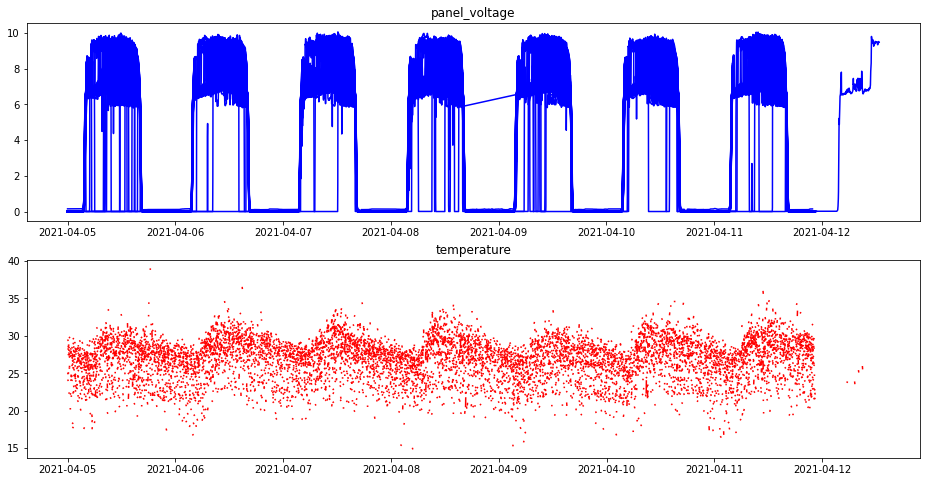

In [7]:
plt.rcParams['figure.figsize'] = [16, 8]
xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)
fig, (ax1,ax2) = plt.subplots(2)

ind = 0
for ind,sample in enumerate(all_samples):
    begin = int(index_list[ind])
    dates = all_samples[ind].loc[begin : begin+dur_time, "timestamp"]
    panel_volt = all_samples[ind].loc[begin : begin+dur_time, "panel_voltage"].values
    temperature = all_samples[ind].loc[begin : begin+dur_time, "temperature"].values
    ax1.plot_date(dates,panel_volt,'b-')
    ax2.plot_date(dates,temperature,'r-')
ax1.set_title('panel_voltage')
ax2.set_title('temperature')

The second idea here is observing **current related features**, they are, **current_out**, **usb_current**  
Here, since our main goal is to clustering cell usage profiles,  
I didnt use **current_in**, which corresponding to input current rather than output for the cell.

From the visualization, I found there exists two level of differences:
1. time level: cells are intensely used in different time periods (details in clustering model section)
2. equipment level: cells are used for powering different equipments.  
There are clear CC-CV current profiles (constant current followed by a exponential decay) which corresponding to charging smartphones. (mainly in 'usb_current')  
There are constant current followed by a instant drop, which corresponding to other non-charging application (for example LED)


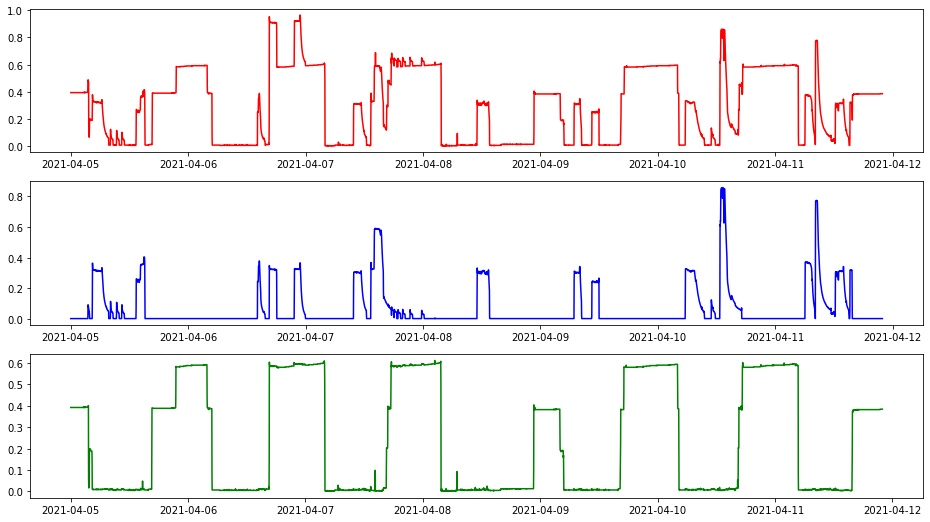

In [8]:
# Basic Visualization for different current features (current_out/usb_current) and different cells (No. 0/10)

plt.rcParams['figure.figsize'] = [16, 9]

fig, (ax1,ax2,ax3) = plt.subplots(3)
dur_time = 7*24*30
ind1,ind2,ind3 = 0,0,10
begin1 = int(index_list[ind1])
begin2 = int(index_list[ind2])
begin3 = int(index_list[ind3])


dates1 = matplotlib.dates.date2num(all_samples[ind1].loc[begin1 : begin1+dur_time, "timestamp"])
current1 = all_samples[ind1].loc[begin1 : begin1+dur_time, "current_out"].values

dates2 = matplotlib.dates.date2num(all_samples[ind2].loc[begin2 : begin2+dur_time, "timestamp"])
current2 = all_samples[ind2].loc[begin2 : begin2+dur_time, "usb_current"].values

dates3 = matplotlib.dates.date2num(all_samples[ind3].loc[begin3 : begin3+dur_time, "timestamp"])
current3 = all_samples[ind3].loc[begin3 : begin3+dur_time, "usb_current"].values

ax1.plot(dates1,current1,'r',label='0')
ax2.plot(dates2,current2,'b',label='10')
ax3.plot(dates3,current1-current2,'g',label='100')

ax1.xaxis.set_major_locator(xtick_locator)
ax1.xaxis.set_major_formatter(xtick_formatter)

ax2.xaxis.set_major_locator(xtick_locator)
ax2.xaxis.set_major_formatter(xtick_formatter)

ax3.xaxis.set_major_locator(xtick_locator)
ax3.xaxis.set_major_formatter(xtick_formatter)

## Cluster Model 1: K-means with Euclidean distance  
Since we have an intuition: there are different usage patterns within current related pattern  
especially, **usb_currnet** and **current_out - usb_current**  
Here, I used an naive K-means model to do the first dirty clustering on these current features.

In [47]:
# Convert all_samples into a ndarray for later usage
dur_time = 1*24*30
week_all_data = []

for i,index in enumerate(index_list):
    index = int(index)
    curr_data = all_samples[i].loc[index:index+dur_time,'usb_current'].values
    # curr_data = all_samples[i].loc[index:index+dur_time,'current_out'].values - all_samples[i].loc[index:index+dur_time,'usb_current'].values
    week_all_data.append(curr_data)
week_all_data = np.asarray(week_all_data)

In [48]:
# Different cluster numbers are tried ranging from 2 to 8  
# cluster numbers = 4 is used here as an example  
# more sophisticated way to determine cluster number is shown in Parameter Optimization section
from tslearn.clustering import TimeSeriesKMeans
cluster_num = 4

km = TimeSeriesKMeans(n_clusters=cluster_num, metric="euclidean", max_iter=50,
                        random_state=666).fit(week_all_data)

y_pred = km.predict(week_all_data)
index0 = int(index_list[0])
(uniques,counts) = np.unique(y_pred, return_counts=True)
date_time =  all_samples[0].loc[index0:index0+dur_time,'timestamp']

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 199 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


The clustering result on **usb_current** mainly indicates time level differences:  
The usb ports of bpower20 are frequently used for charging purpose  
Cluster 0: heavily used in **_morning (5 am – 2 pm)_**  
Cluster 1: heavily used in **_night (5 pm – 11 pm)_**  
Cluster 2: Not Clear, used equily intense **_during the whole day_**  
Cluster 3: heavily used in **_daytime (9 am – 6 pm)_**  



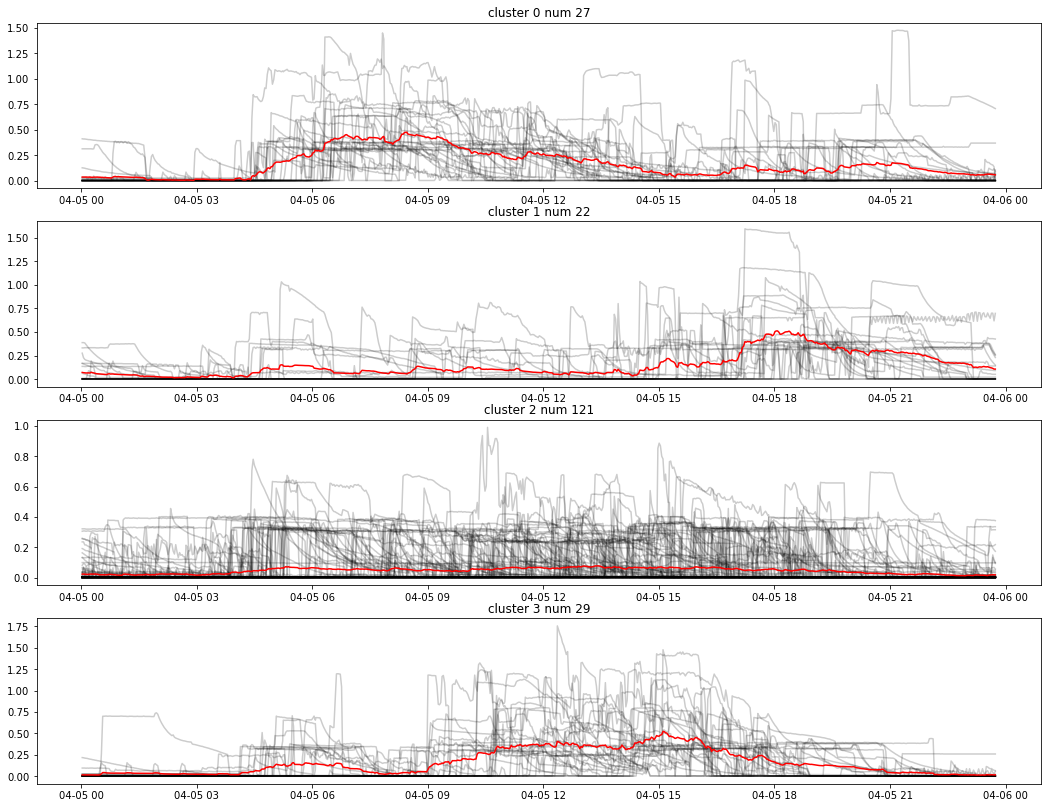

In [49]:
plt.rcParams['figure.figsize'] = [18, 14]
for i in range(cluster_num):
    plt.subplot(cluster_num, 1, i + 1)
    for xx in week_all_data[y_pred == i]: 
        plt.plot_date(date_time,xx.ravel(), "k-", alpha=.2)
    plt.plot_date(date_time,km.cluster_centers_[i].ravel(), "r-")
    plt.title('cluster '+str(i)+' num '+str(counts[i]))

Also, we may see these differences in time level more clear by averaging current within each hour

In [31]:
# count the average usage during each hour 
week_hourly_data = np.zeros([week_all_data.shape[0],24])
for i in range(week_all_data.shape[0]):
    for h in range(24):
        avg_value = np.mean(week_all_data[i,h*30:(h+1)*30])
        week_hourly_data[i,h] = avg_value

km_hour = TimeSeriesKMeans(n_clusters=cluster_num, metric="euclidean", max_iter=50,
                        random_state=666).fit(week_hourly_data)

y_pred_hour = km_hour.predict(week_hourly_data)
(uniques,counts) = np.unique(y_pred_hour, return_counts=True)
time_hour = np.arange(0,24,1)

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 199 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


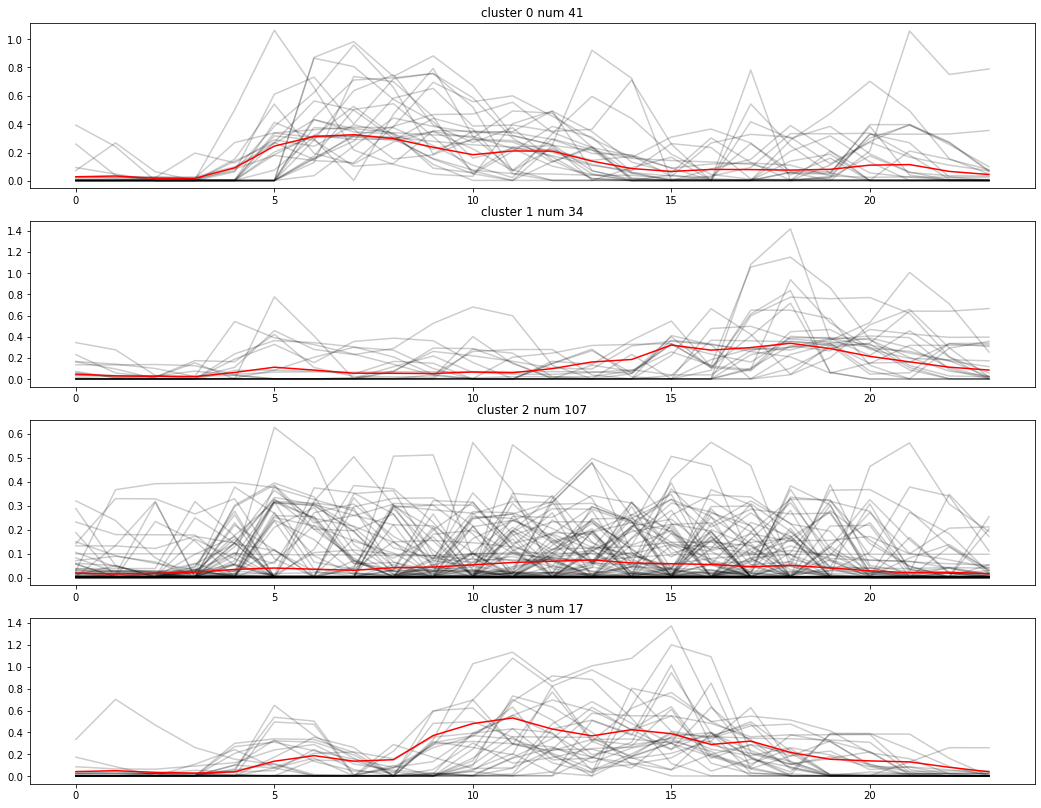

In [32]:
plt.rcParams['figure.figsize'] = [18, 14]
for yi in range(cluster_num):
    plt.subplot(4, 1, yi + 1)
    for xx in week_hourly_data[y_pred == yi]: 
        plt.plot(time_hour,xx.ravel(), "k-", alpha=.2)
    plt.plot(time_hour,km_hour.cluster_centers_[yi].ravel(), "r-")
    plt.title('cluster '+str(yi)+' num '+str(counts[yi]))

## Visualization by t-SNE  
Here, I use t-SNE to reduce the dimension of usb_current curve  
so that we can plot samples in a 2D figure

However, the boundary between different clusters is not very clear  
maybe because of 2 dimentions are not enough to describe the differences we observed from raw usb_current curve

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


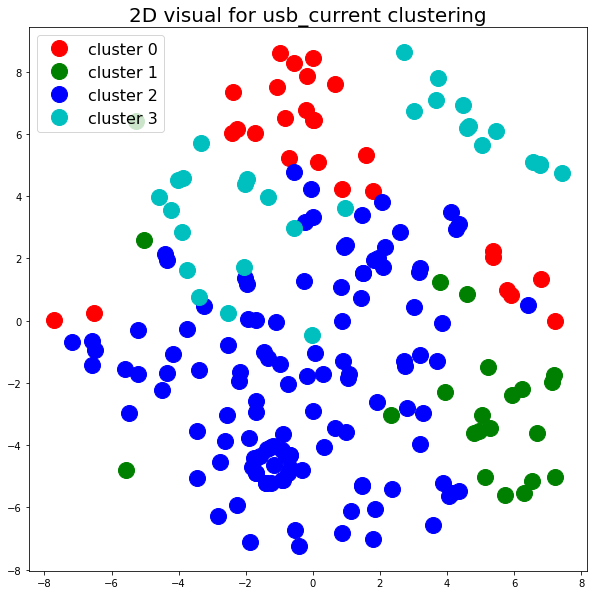

In [34]:
tsne = TSNE(n_components=2, init='pca', random_state=1)
week_all_data_embedded = TSNE(n_components=2, init='pca',learning_rate='auto').fit_transform(week_all_data)

plt.rcParams['figure.figsize'] = [10,10]
color_list = ['r','g','b','c']
for i in range(cluster_num):
    curr_samples = np.where(y_pred == i)[0]
    for ind,ii in enumerate(curr_samples):
        if ind == 0:
            plt.plot(week_all_data_embedded[ii,0],week_all_data_embedded[ii,1] ,
                    "o", markersize=16, linewidth=1, color=color_list[i], label='cluster '+str(i))
        else:
            plt.plot(week_all_data_embedded[ii,0],week_all_data_embedded[ii,1] ,
                    "o", markersize=16, linewidth=1, color=color_list[i])
plt.title('2D visual for usb_current clustering',fontsize = 20)
plt.legend(fontsize=16)



## K-means on (current_out - usb_current) & Visualization

Here, I repeated the process on **current_out - usb_current** curve

In [40]:
dur_time = 7*24*30
week_all_data = []

for i,index in enumerate(index_list):
    index = int(index)
    # curr_data = all_samples[i].loc[index:index+dur_time,'usb_current'].values
    curr_data = all_samples[i].loc[index:index+dur_time,'current_out'].values - all_samples[i].loc[index:index+dur_time,'usb_current'].values
    week_all_data.append(curr_data)
week_all_data = np.asarray(week_all_data)

In [41]:
cluster_num = 4

km = TimeSeriesKMeans(n_clusters=cluster_num, metric="euclidean", max_iter=50,
                        random_state=666).fit(week_all_data)

y_pred = km.predict(week_all_data)
index0 = int(index_list[0])
(uniques,counts) = np.unique(y_pred, return_counts=True)
date_time =  all_samples[0].loc[index0:index0+dur_time,'timestamp']

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 199 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


The clustering result on **current_out - usb_current** mainly indicates **equipment level differences**:  
The barrel jacks of bpower20 are tensely used almost for same time periods, but for different purposes (required different output current values)  
For cluster 0 & 2, the middle platforms locate on different current values, i.e. **0.2A for cluster 0/ 0.4A for cluster 2**  
For cluster 1, cells are in **rest** except for evening  
For cluster 3, cells are almost **always operating at 0.2A**, with also heavily usage for evening  


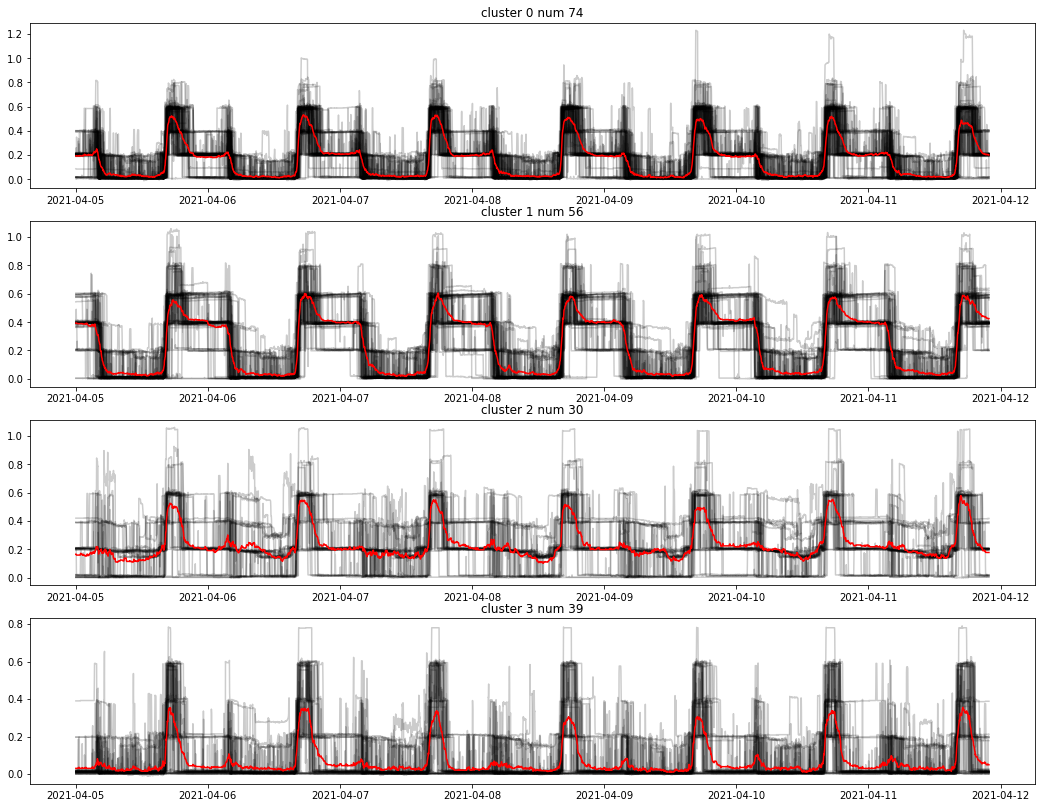

In [42]:
plt.rcParams['figure.figsize'] = [18, 14]
for i in range(cluster_num):
    plt.subplot(cluster_num, 1, i + 1)
    for xx in week_all_data[y_pred == i]: 
        plt.plot_date(date_time,xx.ravel(), "k-", alpha=.2)
    plt.plot_date(date_time,km.cluster_centers_[i].ravel(), "r-")
    plt.title('cluster '+str(i)+' num '+str(counts[i]))

The boundary between different clusters is clear 
which indicates (current_out - usb_current) is a very good feature 

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


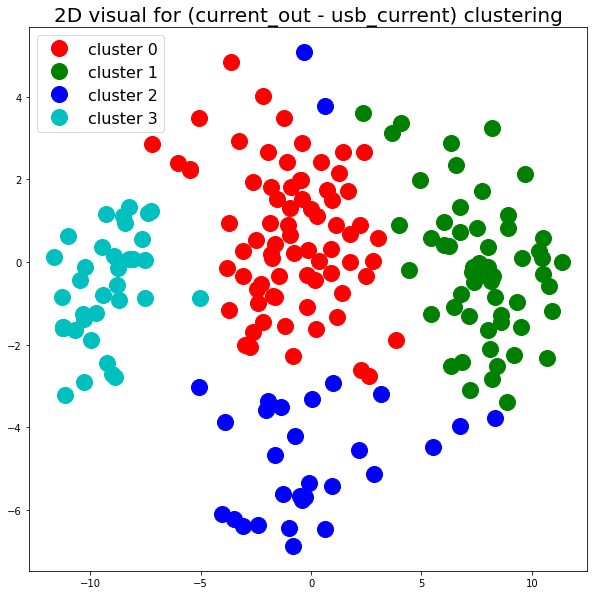

In [43]:
tsne = TSNE(n_components=2, init='pca', random_state=1)
week_all_data_embedded = TSNE(n_components=2, init='pca',learning_rate='auto').fit_transform(week_all_data)

plt.rcParams['figure.figsize'] = [10,10]
color_list = ['r','g','b','c']
for i in range(cluster_num):
    curr_samples = np.where(y_pred == i)[0]
    for ind,ii in enumerate(curr_samples):
        if ind == 0:
            plt.plot(week_all_data_embedded[ii,0],week_all_data_embedded[ii,1] ,
                    "o", markersize=16, linewidth=1, color=color_list[i], label='cluster '+str(i))
        else:
            plt.plot(week_all_data_embedded[ii,0],week_all_data_embedded[ii,1] ,
                    "o", markersize=16, linewidth=1, color=color_list[i])
plt.title('2D visual for (current_out - usb_current) clustering',fontsize = 20)
plt.legend(fontsize=16)


## Parameter Optimization  
Here we use three different methods to decide **cluster number**  
1. Elbow Method (empirical)  
2. Canopy Algorithm (pre-clustering)     
3. Silhouette Score  (performance metrics)

## Cluster Model 2: DBSCAN

## Fan